# Iterative Approach for Unet Training 

------

## Overview



The purpose of this learn.ipynb notebook is to investigate whether an image can exhibit a preference for being segmented more effectively using a UNet model trained on polar or cartesian-dominant images.




-----


## File Structure
```
data
└── endoscopic
    ├── cartesian
    │   ├── image
    │   └── label
    └── polar
        ├── image
        └── label
```

Inside of each end folder there are 956 images, named as `0.tif` to `955.tif`
and I believe, for now, the naming of the images are one to one correctly matched, meaning the ``/data/endoscopic/**cartesian**/image/0.tif`` is transformed from `/data/endoscopic/**polar**/image/0.tif`

Instead of putting a seperate set of images aside to be test set, we chose to use k-fold cross validation.

In [1]:
from defines import *
from model import *
from data import *
import sys

from numpy import loadtxt
from keras.models import load_model
from PIL import Image

from sklearn.model_selection import KFold
from skimage.io import imread
from skimage import img_as_ubyte
from skimage.transform import resize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import math
import shutil

In [ ]:
# Import from files and libraries

In [2]:
#run this if your computer has a cuda visible device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
print(PARAM_SYSTEM_TIME)

In [ ]:
# Test code for correct file structure setup

In [ ]:
# Visualize folder tree in current directory
os.system("tree -d")

In [ ]:
#count of files in data directories
os.system("ls " + os.path.join(PARAM_PATH_CARTE,PARAM_IMG_FOLDER) + " | wc -l")
os.system("ls " + os.path.join(PARAM_PATH_CARTE,PARAM_MSK_FOLDER) + " | wc -l")
os.system("ls " + os.path.join(PARAM_PATH_POLAR,PARAM_IMG_FOLDER) + " | wc -l")
os.system("ls " + os.path.join(PARAM_PATH_POLAR,PARAM_MSK_FOLDER) + " | wc -l")


*Expected Output:
7404\
7404\
7404\
7404\
*

----

## File Relocation

In the following block, the code loads in one analysis file from previous research. 

### #File name postfix
_C_ is the dice scores of the predictions generated by Unet C: this Unet C is trained using all 7404 images, in their cartesian form. The raw image was directly input into the Unet and the prediction was generated.

_P_ is the dice scores of the predictions generated by Unet P: this Unet P is trained using all 7404 images but in their polar form. The raw images were transformed, and then input for prediction. The prediction is in polar space.

_P2C_ is the dice scores of the predictions generated by the same Unet P as mentioned above, but the dice score is generated by transforming the prediction back to cartesian, and compared to their original label.

In [3]:
#file_name = 'analysis_dice_back_Test_C.npy'
#file_name = 'analysis_dice_back_Test_P.npy'
#file_name = 'analysis_dice_back_Test_P2C.npy'
file_name = 'analysis_dice_back_Train_C.npy'

np_file = os.path.join(PARAM_PATH_SCORES, file_name)
#load npy file
img_score = np.load(np_file)

#sort scores in descending order and store index
sorted_score = np.flip(np.argsort(img_score))

#------DEBUG--------
#print(len(sorted_score))


The `sorted_score` should be a list of length 7404, sorted by the method we chose

In [4]:
sorted_score = pd.DataFrame(sorted_score)

#fetch top polar dominant and non-polar dominant image
num_polar = round(len(sorted_score)/2)
num_cartesian = len(sorted_score) - num_polar
dfPolar = sorted_score.head(num_polar)
dfCartesian = sorted_score.tail(num_cartesian)
#print("Polar: \n", dfPolar)
#print("Cartesian: \n", dfCartesian)

Now in `dfPolar` should be the best half of images (filename), which performs better than the other half, according to the data we used above. In `dfCartesian` there's the other half.

In [5]:
from filePrep import *

K = 5

checkNcreateTempFolder(PARAM_PATH_TEMP_POLAR, K)
checkNcreateTempFolder(PARAM_PATH_TEMP_CARTE, K)

The two lines creates the new temporary folder.
Instead of making kfolds later, the kfolds is assigned now.

In [6]:
kf = KFold(n_splits = K, shuffle = True, random_state = 42) 

Use the KFold package to assign the paramters like n_splits and so.


In [7]:
i = 0
for train_index,test_index in kf.split(dfPolar):
    fillFolder(test_index, dfPolar, PARAM_PATH_POLAR, PARAM_PATH_CARTE, PARAM_PATH_TEMP_POLAR, i)
    i += 1
i = 0
print('------------------------------------')
for train_index,test_index in kf.split(dfCartesian):
    fillFolder(test_index, dfCartesian, PARAM_PATH_POLAR, PARAM_PATH_CARTE, PARAM_PATH_TEMP_CARTE, i)
    i += 1

------------------------------------


At this point we should have all `k-folds` set up. The next step is to write a training loop.


Due to the limitation of flow_from_directory, which, it does not allow the combination of multiple directories. And, the limitation of my knowledge of flow_from_dataframe. **I believe this is solvable using flow_from_dataframe** I decide to move training set into a separate temporary folder when training.

In [23]:
working_mother_folder = PARAM_PATH_TEMP_POLAR
batch_size = 4
PARAM_BETA_TEST_NUM = 6
data_gen_args = dict(rotation_range = 80,      # TODO: improve the data augmentation
                width_shift_range =0.02,
                height_shift_range =0.02,
                shear_range = 0.35,
                zoom_range = 0.075,
                horizontal_flip = True,
                fill_mode = 'nearest',
                rescale = 1./255)
score = []
for i in range(K):
    working_test_folder_i = os.path.join(working_mother_folder, str(i), PARAM_SUB_FOLDER_POLAR)
    temp_folder_path = os.path.join(working_mother_folder,'temp')
    os.mkdir(temp_folder_path)
    for j in range(K):
        if i != j:
            for subfolder_name in ['image','label']:
                subfolder_path = os.path.join(working_mother_folder,str(j),'polar',subfolder_name)
                temp_subfolder_path = os.path.join(temp_folder_path,subfolder_name)
                for root, dirs, files in os.walk(subfolder_path):
                    for file in files:
                        src_file = os.path.join(root, file)
                        dest_file = os.path.join(temp_subfolder_path,os.path.relpath(src_file, subfolder_path))
                        os.makedirs(os.path.dirname(dest_file), exist_ok=True)
                        shutil.copy(src_file, dest_file)
    test_gene = trainGenerator(batch_size, temp_folder_path, PARAM_IMG_FOLDER, PARAM_MSK_FOLDER, data_gen_args)
    model = unet(PARAM_BETA1[PARAM_BETA_TEST_NUM], PARAM_BETA2[PARAM_BETA_TEST_NUM]) 
    model_checkpoint = ModelCheckpoint(os.path.join(working_mother_folder,'checkpoint.hdf5'), monitor = 'loss', verbose=1, save_best_only=True)
    test_run = model.fit(test_gene, verbose = 1, steps_per_epoch = 100, epochs = 100, callbacks = [model_checkpoint])
    score.append(test_run)
    shutil.rmtree(temp_folder_path)

Found 2961 images belonging to 1 classes.
Found 2961 images belonging to 1 classes.
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - ETA: 0s - loss: 0.6402 - accuracy: 0.4389 - dice_coef_loss: 0.6402
Epoch 1: loss improved from inf to 0.64016, saving model to ./temp/polar_Dom/checkpoint.hdf5
100/100 [==============================] - 27s 264ms/step - loss: 0.6402 - accu

100/100 [==============================] - 26s 260ms/step - loss: 0.5680 - accuracy: 0.8400 - dice_coef_loss: 0.5680
Epoch 25/100
100/100 [==============================] - ETA: 0s - loss: 0.5598 - accuracy: 0.8380 - dice_coef_loss: 0.5598
Epoch 25: loss did not improve from 0.55871
100/100 [==============================] - 26s 260ms/step - loss: 0.5598 - accuracy: 0.8380 - dice_coef_loss: 0.5598
Epoch 26/100
100/100 [==============================] - ETA: 0s - loss: 0.5598 - accuracy: 0.8400 - dice_coef_loss: 0.5598
Epoch 26: loss did not improve from 0.55871
100/100 [==============================] - 26s 260ms/step - loss: 0.5598 - accuracy: 0.8400 - dice_coef_loss: 0.5598
Epoch 27/100
100/100 [==============================] - ETA: 0s - loss: 0.5485 - accuracy: 0.8428 - dice_coef_loss: 0.5485
Epoch 27: loss improved from 0.55871 to 0.54852, saving model to ./temp/polar_Dom/checkpoint.hdf5
100/100 [==============================] - 27s 268ms/step - loss: 0.5485 - accuracy: 0.8428 - 

Epoch 53/100
100/100 [==============================] - ETA: 0s - loss: 0.5533 - accuracy: 0.8574 - dice_coef_loss: 0.5533
Epoch 53: loss did not improve from 0.54683
100/100 [==============================] - 26s 260ms/step - loss: 0.5533 - accuracy: 0.8574 - dice_coef_loss: 0.5533
Epoch 54/100
100/100 [==============================] - ETA: 0s - loss: 0.5472 - accuracy: 0.8611 - dice_coef_loss: 0.5472
Epoch 54: loss did not improve from 0.54683
100/100 [==============================] - 26s 260ms/step - loss: 0.5472 - accuracy: 0.8611 - dice_coef_loss: 0.5472
Epoch 55/100
100/100 [==============================] - ETA: 0s - loss: 0.5621 - accuracy: 0.8709 - dice_coef_loss: 0.5621
Epoch 55: loss did not improve from 0.54683
100/100 [==============================] - 26s 260ms/step - loss: 0.5621 - accuracy: 0.8709 - dice_coef_loss: 0.5621
Epoch 56/100
100/100 [==============================] - ETA: 0s - loss: 0.5440 - accuracy: 0.8630 - dice_coef_loss: 0.5440
Epoch 56: loss improved f

Epoch 81/100
100/100 [==============================] - ETA: 0s - loss: 0.5408 - accuracy: 0.8785 - dice_coef_loss: 0.5408
Epoch 81: loss did not improve from 0.53415
100/100 [==============================] - 26s 260ms/step - loss: 0.5408 - accuracy: 0.8785 - dice_coef_loss: 0.5408
Epoch 82/100
100/100 [==============================] - ETA: 0s - loss: 0.5419 - accuracy: 0.8679 - dice_coef_loss: 0.5415
Epoch 82: loss did not improve from 0.53415
100/100 [==============================] - 26s 258ms/step - loss: 0.5419 - accuracy: 0.8679 - dice_coef_loss: 0.5415
Epoch 83/100
100/100 [==============================] - ETA: 0s - loss: 0.5308 - accuracy: 0.8767 - dice_coef_loss: 0.5308
Epoch 83: loss improved from 0.53415 to 0.53082, saving model to ./temp/polar_Dom/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.5308 - accuracy: 0.8767 - dice_coef_loss: 0.5308
Epoch 84/100
100/100 [==============================] - ETA: 0s - loss: 0.5411 - accuracy: 0.8

100/100 [==============================] - ETA: 0s - loss: 0.5803 - accuracy: 0.7855 - dice_coef_loss: 0.5803
Epoch 5: loss improved from 0.58266 to 0.58026, saving model to ./temp/polar_Dom/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.5803 - accuracy: 0.7855 - dice_coef_loss: 0.5803
Epoch 6/100
100/100 [==============================] - ETA: 0s - loss: 0.5822 - accuracy: 0.7864 - dice_coef_loss: 0.5822
Epoch 6: loss did not improve from 0.58026
100/100 [==============================] - 26s 260ms/step - loss: 0.5822 - accuracy: 0.7864 - dice_coef_loss: 0.5822
Epoch 7/100
100/100 [==============================] - ETA: 0s - loss: 0.5764 - accuracy: 0.8063 - dice_coef_loss: 0.5764
Epoch 7: loss improved from 0.58026 to 0.57639, saving model to ./temp/polar_Dom/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.5764 - accuracy: 0.8063 - dice_coef_loss: 0.5764
Epoch 8/100
100/100 [==============================] - ETA

100/100 [==============================] - ETA: 0s - loss: 0.5534 - accuracy: 0.8411 - dice_coef_loss: 0.5534
Epoch 32: loss did not improve from 0.54235
100/100 [==============================] - 26s 261ms/step - loss: 0.5534 - accuracy: 0.8411 - dice_coef_loss: 0.5534
Epoch 33/100
100/100 [==============================] - ETA: 0s - loss: 0.5547 - accuracy: 0.8554 - dice_coef_loss: 0.5547
Epoch 33: loss did not improve from 0.54235
100/100 [==============================] - 26s 261ms/step - loss: 0.5547 - accuracy: 0.8554 - dice_coef_loss: 0.5547
Epoch 34/100
100/100 [==============================] - ETA: 0s - loss: 0.5634 - accuracy: 0.8527 - dice_coef_loss: 0.5634
Epoch 34: loss did not improve from 0.54235
100/100 [==============================] - 26s 262ms/step - loss: 0.5634 - accuracy: 0.8527 - dice_coef_loss: 0.5634
Epoch 35/100
100/100 [==============================] - ETA: 0s - loss: 0.5632 - accuracy: 0.8497 - dice_coef_loss: 0.5632
Epoch 35: loss did not improve from 0.

100/100 [==============================] - 26s 258ms/step - loss: 0.5473 - accuracy: 0.8641 - dice_coef_loss: 0.5471
Epoch 61/100
100/100 [==============================] - ETA: 0s - loss: 0.5423 - accuracy: 0.8719 - dice_coef_loss: 0.5423
Epoch 61: loss did not improve from 0.53864
100/100 [==============================] - 26s 260ms/step - loss: 0.5423 - accuracy: 0.8719 - dice_coef_loss: 0.5423
Epoch 62/100
100/100 [==============================] - ETA: 0s - loss: 0.5370 - accuracy: 0.8701 - dice_coef_loss: 0.5370
Epoch 62: loss improved from 0.53864 to 0.53696, saving model to ./temp/polar_Dom/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.5370 - accuracy: 0.8701 - dice_coef_loss: 0.5370
Epoch 63/100
100/100 [==============================] - ETA: 0s - loss: 0.5520 - accuracy: 0.8684 - dice_coef_loss: 0.5520
Epoch 63: loss did not improve from 0.53696
100/100 [==============================] - 26s 260ms/step - loss: 0.5520 - accuracy: 0.8684 - 

100/100 [==============================] - ETA: 0s - loss: 0.5425 - accuracy: 0.8774 - dice_coef_loss: 0.5421
Epoch 89: loss did not improve from 0.53253
100/100 [==============================] - 26s 258ms/step - loss: 0.5425 - accuracy: 0.8774 - dice_coef_loss: 0.5421
Epoch 90/100
100/100 [==============================] - ETA: 0s - loss: 0.5401 - accuracy: 0.8804 - dice_coef_loss: 0.5401
Epoch 90: loss did not improve from 0.53253
100/100 [==============================] - 26s 260ms/step - loss: 0.5401 - accuracy: 0.8804 - dice_coef_loss: 0.5401
Epoch 91/100
100/100 [==============================] - ETA: 0s - loss: 0.5311 - accuracy: 0.8818 - dice_coef_loss: 0.5311
Epoch 91: loss improved from 0.53253 to 0.53111, saving model to ./temp/polar_Dom/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.5311 - accuracy: 0.8818 - dice_coef_loss: 0.5311
Epoch 92/100
100/100 [==============================] - ETA: 0s - loss: 0.5413 - accuracy: 0.8811 - dice_co

100/100 [==============================] - 27s 266ms/step - loss: 0.4972 - accuracy: 0.8510 - dice_coef_loss: 0.4972
Epoch 13/100
100/100 [==============================] - ETA: 0s - loss: 0.5078 - accuracy: 0.8511 - dice_coef_loss: 0.5078
Epoch 13: loss did not improve from 0.49721
100/100 [==============================] - 26s 259ms/step - loss: 0.5078 - accuracy: 0.8511 - dice_coef_loss: 0.5078
Epoch 14/100
100/100 [==============================] - ETA: 0s - loss: 0.4883 - accuracy: 0.8589 - dice_coef_loss: 0.4883
Epoch 14: loss improved from 0.49721 to 0.48826, saving model to ./temp/polar_Dom/checkpoint.hdf5
100/100 [==============================] - 27s 266ms/step - loss: 0.4883 - accuracy: 0.8589 - dice_coef_loss: 0.4883
Epoch 15/100
100/100 [==============================] - ETA: 0s - loss: 0.5062 - accuracy: 0.8494 - dice_coef_loss: 0.5062
Epoch 15: loss did not improve from 0.48826
100/100 [==============================] - 26s 258ms/step - loss: 0.5062 - accuracy: 0.8494 - 

100/100 [==============================] - 27s 266ms/step - loss: 0.4588 - accuracy: 0.8771 - dice_coef_loss: 0.4588
Epoch 41/100
100/100 [==============================] - ETA: 0s - loss: 0.4630 - accuracy: 0.8703 - dice_coef_loss: 0.4630
Epoch 41: loss did not improve from 0.45880
100/100 [==============================] - 26s 259ms/step - loss: 0.4630 - accuracy: 0.8703 - dice_coef_loss: 0.4630
Epoch 42/100
100/100 [==============================] - ETA: 0s - loss: 0.4593 - accuracy: 0.8734 - dice_coef_loss: 0.4593
Epoch 42: loss did not improve from 0.45880
100/100 [==============================] - 26s 259ms/step - loss: 0.4593 - accuracy: 0.8734 - dice_coef_loss: 0.4593
Epoch 43/100
100/100 [==============================] - ETA: 0s - loss: 0.4628 - accuracy: 0.8708 - dice_coef_loss: 0.4628
Epoch 43: loss did not improve from 0.45880
100/100 [==============================] - 26s 259ms/step - loss: 0.4628 - accuracy: 0.8708 - dice_coef_loss: 0.4628
Epoch 44/100
100/100 [=========

100/100 [==============================] - ETA: 0s - loss: 0.4390 - accuracy: 0.8819 - dice_coef_loss: 0.4390
Epoch 68: loss did not improve from 0.43814
100/100 [==============================] - 26s 259ms/step - loss: 0.4390 - accuracy: 0.8819 - dice_coef_loss: 0.4390
Epoch 69/100
100/100 [==============================] - ETA: 0s - loss: 0.4375 - accuracy: 0.8878 - dice_coef_loss: 0.4375
Epoch 69: loss improved from 0.43814 to 0.43754, saving model to ./temp/polar_Dom/checkpoint.hdf5
100/100 [==============================] - 27s 266ms/step - loss: 0.4375 - accuracy: 0.8878 - dice_coef_loss: 0.4375
Epoch 70/100
100/100 [==============================] - ETA: 0s - loss: 0.4491 - accuracy: 0.8812 - dice_coef_loss: 0.4491
Epoch 70: loss did not improve from 0.43754
100/100 [==============================] - 26s 259ms/step - loss: 0.4491 - accuracy: 0.8812 - dice_coef_loss: 0.4491
Epoch 71/100
100/100 [==============================] - ETA: 0s - loss: 0.4365 - accuracy: 0.8895 - dice_co

Epoch 96/100
100/100 [==============================] - ETA: 0s - loss: 0.4273 - accuracy: 0.8923 - dice_coef_loss: 0.4273
Epoch 96: loss did not improve from 0.41962
100/100 [==============================] - 26s 259ms/step - loss: 0.4273 - accuracy: 0.8923 - dice_coef_loss: 0.4273
Epoch 97/100
100/100 [==============================] - ETA: 0s - loss: 0.4220 - accuracy: 0.8964 - dice_coef_loss: 0.4220
Epoch 97: loss did not improve from 0.41962
100/100 [==============================] - 26s 258ms/step - loss: 0.4220 - accuracy: 0.8964 - dice_coef_loss: 0.4220
Epoch 98/100
100/100 [==============================] - ETA: 0s - loss: 0.4240 - accuracy: 0.8950 - dice_coef_loss: 0.4240
Epoch 98: loss did not improve from 0.41962
100/100 [==============================] - 26s 259ms/step - loss: 0.4240 - accuracy: 0.8950 - dice_coef_loss: 0.4240
Epoch 99/100
100/100 [==============================] - ETA: 0s - loss: 0.4295 - accuracy: 0.8936 - dice_coef_loss: 0.4295
Epoch 99: loss did not im

Epoch 19/100
100/100 [==============================] - ETA: 0s - loss: 0.4964 - accuracy: 0.8582 - dice_coef_loss: 0.4964
Epoch 19: loss did not improve from 0.49404
100/100 [==============================] - 26s 260ms/step - loss: 0.4964 - accuracy: 0.8582 - dice_coef_loss: 0.4964
Epoch 20/100
100/100 [==============================] - ETA: 0s - loss: 0.4810 - accuracy: 0.8601 - dice_coef_loss: 0.4810
Epoch 20: loss improved from 0.49404 to 0.48101, saving model to ./temp/polar_Dom/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.4810 - accuracy: 0.8601 - dice_coef_loss: 0.4810
Epoch 21/100
100/100 [==============================] - ETA: 0s - loss: 0.4813 - accuracy: 0.8637 - dice_coef_loss: 0.4813
Epoch 21: loss did not improve from 0.48101
100/100 [==============================] - 26s 259ms/step - loss: 0.4813 - accuracy: 0.8637 - dice_coef_loss: 0.4813
Epoch 22/100
100/100 [==============================] - ETA: 0s - loss: 0.4860 - accuracy: 0.8

Epoch 47/100
100/100 [==============================] - ETA: 0s - loss: 0.4609 - accuracy: 0.8761 - dice_coef_loss: 0.4609
Epoch 47: loss did not improve from 0.45567
100/100 [==============================] - 26s 259ms/step - loss: 0.4609 - accuracy: 0.8761 - dice_coef_loss: 0.4609
Epoch 48/100
100/100 [==============================] - ETA: 0s - loss: 0.4535 - accuracy: 0.8781 - dice_coef_loss: 0.4535
Epoch 48: loss improved from 0.45567 to 0.45349, saving model to ./temp/polar_Dom/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.4535 - accuracy: 0.8781 - dice_coef_loss: 0.4535
Epoch 49/100
100/100 [==============================] - ETA: 0s - loss: 0.4557 - accuracy: 0.8798 - dice_coef_loss: 0.4557
Epoch 49: loss did not improve from 0.45349
100/100 [==============================] - 26s 260ms/step - loss: 0.4557 - accuracy: 0.8798 - dice_coef_loss: 0.4557
Epoch 50/100
100/100 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.8

Epoch 74/100
100/100 [==============================] - ETA: 0s - loss: 0.4363 - accuracy: 0.8876 - dice_coef_loss: 0.4363
Epoch 74: loss did not improve from 0.43180
100/100 [==============================] - 26s 259ms/step - loss: 0.4363 - accuracy: 0.8876 - dice_coef_loss: 0.4363
Epoch 75/100
100/100 [==============================] - ETA: 0s - loss: 0.4330 - accuracy: 0.8933 - dice_coef_loss: 0.4330
Epoch 75: loss did not improve from 0.43180
100/100 [==============================] - 26s 258ms/step - loss: 0.4330 - accuracy: 0.8933 - dice_coef_loss: 0.4330
Epoch 76/100
100/100 [==============================] - ETA: 0s - loss: 0.4341 - accuracy: 0.8890 - dice_coef_loss: 0.4341
Epoch 76: loss did not improve from 0.43180
100/100 [==============================] - 26s 259ms/step - loss: 0.4341 - accuracy: 0.8890 - dice_coef_loss: 0.4341
Epoch 77/100
100/100 [==============================] - ETA: 0s - loss: 0.4397 - accuracy: 0.8880 - dice_coef_loss: 0.4397
Epoch 77: loss did not im

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - ETA: 0s - loss: 0.6861 - accuracy: 0.6190 - dice_coef_loss: 0.6861
Epoch 1: loss improved from inf to 0.68612, saving model to ./temp/polar_Dom/checkpoint.hdf5
100/100 [==============================] - 28s 267ms/step - loss: 0.6861 - accuracy: 0.6190 - dice_coef_loss: 0.6861
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.6192 - accuracy: 0.7528 - dice_coef_loss: 0.6192
Epoch 2: loss improved from 0.68612 to 0.61918, saving model to ./temp/polar_Dom/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.6192 - accuracy: 0.7528 - dice_coef_loss: 0.6192
Epoch 3/100
100/100 [============

100/100 [==============================] - 27s 266ms/step - loss: 0.4700 - accuracy: 0.8696 - dice_coef_loss: 0.4700
Epoch 26/100
100/100 [==============================] - ETA: 0s - loss: 0.4799 - accuracy: 0.8684 - dice_coef_loss: 0.4799
Epoch 26: loss did not improve from 0.47001
100/100 [==============================] - 26s 258ms/step - loss: 0.4799 - accuracy: 0.8684 - dice_coef_loss: 0.4799
Epoch 27/100
100/100 [==============================] - ETA: 0s - loss: 0.4746 - accuracy: 0.8690 - dice_coef_loss: 0.4746
Epoch 27: loss did not improve from 0.47001
100/100 [==============================] - 26s 258ms/step - loss: 0.4746 - accuracy: 0.8690 - dice_coef_loss: 0.4746
Epoch 28/100
100/100 [==============================] - ETA: 0s - loss: 0.4803 - accuracy: 0.8643 - dice_coef_loss: 0.4803
Epoch 28: loss did not improve from 0.47001
100/100 [==============================] - 26s 258ms/step - loss: 0.4803 - accuracy: 0.8643 - dice_coef_loss: 0.4803
Epoch 29/100
100/100 [=========

100/100 [==============================] - ETA: 0s - loss: 0.4605 - accuracy: 0.8757 - dice_coef_loss: 0.4605
Epoch 53: loss did not improve from 0.45126
100/100 [==============================] - 26s 258ms/step - loss: 0.4605 - accuracy: 0.8757 - dice_coef_loss: 0.4605
Epoch 54/100
100/100 [==============================] - ETA: 0s - loss: 0.4434 - accuracy: 0.8855 - dice_coef_loss: 0.4434
Epoch 54: loss improved from 0.45126 to 0.44344, saving model to ./temp/polar_Dom/checkpoint.hdf5
100/100 [==============================] - 27s 266ms/step - loss: 0.4434 - accuracy: 0.8855 - dice_coef_loss: 0.4434
Epoch 55/100
100/100 [==============================] - ETA: 0s - loss: 0.4399 - accuracy: 0.8866 - dice_coef_loss: 0.4399
Epoch 55: loss improved from 0.44344 to 0.43989, saving model to ./temp/polar_Dom/checkpoint.hdf5
100/100 [==============================] - 27s 267ms/step - loss: 0.4399 - accuracy: 0.8866 - dice_coef_loss: 0.4399
Epoch 56/100
100/100 [==============================]

100/100 [==============================] - 27s 266ms/step - loss: 0.4273 - accuracy: 0.8938 - dice_coef_loss: 0.4273
Epoch 81/100
100/100 [==============================] - ETA: 0s - loss: 0.4362 - accuracy: 0.8861 - dice_coef_loss: 0.4362
Epoch 81: loss did not improve from 0.42728
100/100 [==============================] - 26s 258ms/step - loss: 0.4362 - accuracy: 0.8861 - dice_coef_loss: 0.4362
Epoch 82/100
100/100 [==============================] - ETA: 0s - loss: 0.4342 - accuracy: 0.8861 - dice_coef_loss: 0.4343
Epoch 82: loss did not improve from 0.42728
100/100 [==============================] - 26s 257ms/step - loss: 0.4342 - accuracy: 0.8861 - dice_coef_loss: 0.4343
Epoch 83/100
100/100 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.8934 - dice_coef_loss: 0.4268
Epoch 83: loss improved from 0.42728 to 0.42684, saving model to ./temp/polar_Dom/checkpoint.hdf5
100/100 [==============================] - 27s 266ms/step - loss: 0.4268 - accuracy: 0.8934 - 

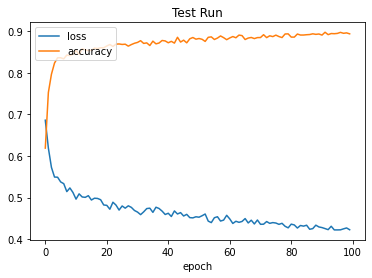

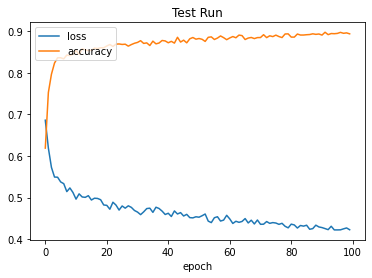

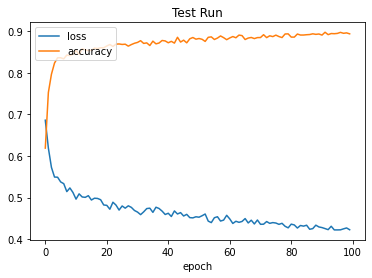

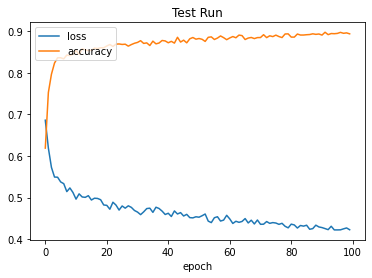

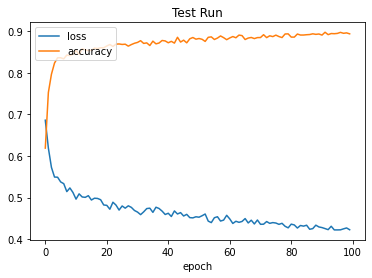

In [25]:
for single_run in score:
    plt.plot(test_run.history['loss'])
    plt.plot(test_run.history['accuracy'])
    plt.title('Test Run')
    plt.xlabel('epoch')
    plt.legend(['loss', 'accuracy'], loc='upper left')
    plt.show()

### Cuiling's K-fold function

In [ ]:
#K fold Validation (obtain training & testing sets)
from sklearn.model_selection import KFold

kfold = KFold(n_splits=PARAM_SPLIT_NUM)
for train_index,test_index in kfold.split(dfPolar):
    polar_train,polar_test=dfPolar.iloc[train_index, :],dfPolar.iloc[test_index, :]
    cartesian_train,cartesian_test=dfCartesian.iloc[train_index, :],dfCartesian.iloc[test_index, :]
    #print("polar train: ", polar_train, "polar test: ", polar_test)
    #print("cartesian train" , cartesian_train, "cartesian test", cartesian_test)
    batch_size = 3
    PARAM_BETA_TEST_NUM = 6
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    data_gen_args = dict(rotation_range = 80,      # TODO: improve the data augmentation
                width_shift_range =0.02,
                height_shift_range =0.02,
                shear_range = 0.35,
                zoom_range = 0.075,
                horizontal_flip = True,
                fill_mode = 'nearest',
                rescale = 1./255)
    print('-------------------------------------------------------------')
    test_model = unet(PARAM_BETA1[PARAM_BETA_TEST_NUM], PARAM_BETA2[PARAM_BETA_TEST_NUM]) 
    test_run = test_model.fit(polar_train, polar_test, verbose = 1, steps_per_epoch = 50, epochs = 5, callbacks = [early_stop])

-----

## Model training test

This part is used to see if we can train a model using the current configuration.

In [ ]:
# Setting Superparameters (temporary) for a test run of model training test

In [ ]:
batch_size = 4
PARAM_BETA_TEST_NUM = 6
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
data_gen_args = dict(rotation_range = 80,      # TODO: improve the data augmentation
                width_shift_range =0.02,
                height_shift_range =0.02,
                shear_range = 0.35,
                zoom_range = 0.075,
                horizontal_flip = True,
                fill_mode = 'nearest',
                rescale = 1./255)
test_gene = trainGenerator(batch_size, PARAM_PATH_CARTE, PARAM_IMG_FOLDER, PARAM_MSK_FOLDER, data_gen_args)
test_model = unet(PARAM_BETA1[PARAM_BETA_TEST_NUM], PARAM_BETA2[PARAM_BETA_TEST_NUM]) 
test_model.summary()

### Expected output
<details>
    <summary><b><font color="green">Click here to expand</font></b></summary>
    <code>
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_120 (Conv2D)            (None, 256, 256, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_121 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_120[0][0]']             
                                )                                                                 
                                                                                                  
 max_pooling2d_20 (MaxPooling2D  (None, 128, 128, 64  0          ['conv2d_121[0][0]']             
 )                              )                                                                 
                                                                                                  
 conv2d_122 (Conv2D)            (None, 128, 128, 12  73856       ['max_pooling2d_20[0][0]']       
                                8)                                                                
                                                                                                  
 conv2d_123 (Conv2D)            (None, 128, 128, 12  147584      ['conv2d_122[0][0]']             
                                8)                                                                
                                                                                                  
 max_pooling2d_21 (MaxPooling2D  (None, 64, 64, 128)  0          ['conv2d_123[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_124 (Conv2D)            (None, 64, 64, 256)  295168      ['max_pooling2d_21[0][0]']       
                                                                                                  
 conv2d_125 (Conv2D)            (None, 64, 64, 256)  590080      ['conv2d_124[0][0]']             
                                                                                                  
 max_pooling2d_22 (MaxPooling2D  (None, 32, 32, 256)  0          ['conv2d_125[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_126 (Conv2D)            (None, 32, 32, 512)  1180160     ['max_pooling2d_22[0][0]']       
                                                                                                  
 conv2d_127 (Conv2D)            (None, 32, 32, 512)  2359808     ['conv2d_126[0][0]']             
                                                                                                  
 dropout_10 (Dropout)           (None, 32, 32, 512)  0           ['conv2d_127[0][0]']             
                                                                                                  
 max_pooling2d_23 (MaxPooling2D  (None, 16, 16, 512)  0          ['dropout_10[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_128 (Conv2D)            (None, 16, 16, 1024  4719616     ['max_pooling2d_23[0][0]']       
                                )                                                                 
                                                                                                  
 conv2d_129 (Conv2D)            (None, 16, 16, 1024  9438208     ['conv2d_128[0][0]']             
                                )                                                                 
                                                                                                  
 dropout_11 (Dropout)           (None, 16, 16, 1024  0           ['conv2d_129[0][0]']             
                                )                                                                 
                                                                                                  
 up_sampling2d_20 (UpSampling2D  (None, 32, 32, 1024  0          ['dropout_11[0][0]']             
 )                              )                                                                 
                                                                                                  
 conv2d_130 (Conv2D)            (None, 32, 32, 512)  2097664     ['up_sampling2d_20[0][0]']       
                                                                                                  
 concatenate_20 (Concatenate)   (None, 32, 32, 1024  0           ['dropout_10[0][0]',             
                                )                                 'conv2d_130[0][0]']             
                                                                                                  
 conv2d_131 (Conv2D)            (None, 32, 32, 512)  4719104     ['concatenate_20[0][0]']         
                                                                                                  
 conv2d_132 (Conv2D)            (None, 32, 32, 512)  2359808     ['conv2d_131[0][0]']             
                                                                                                  
 up_sampling2d_21 (UpSampling2D  (None, 64, 64, 512)  0          ['conv2d_132[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_133 (Conv2D)            (None, 64, 64, 256)  524544      ['up_sampling2d_21[0][0]']       
                                                                                                  
 concatenate_21 (Concatenate)   (None, 64, 64, 512)  0           ['conv2d_125[0][0]',             
                                                                  'conv2d_133[0][0]']             
                                                                                                  
 conv2d_134 (Conv2D)            (None, 64, 64, 256)  1179904     ['concatenate_21[0][0]']         
                                                                                                  
 conv2d_135 (Conv2D)            (None, 64, 64, 256)  590080      ['conv2d_134[0][0]']             
                                                                                                  
 up_sampling2d_22 (UpSampling2D  (None, 128, 128, 25  0          ['conv2d_135[0][0]']             
 )                              6)                                                                
                                                                                                  
 conv2d_136 (Conv2D)            (None, 128, 128, 12  131200      ['up_sampling2d_22[0][0]']       
                                8)                                                                
                                                                                                  
 concatenate_22 (Concatenate)   (None, 128, 128, 25  0           ['conv2d_123[0][0]',             
                                6)                                'conv2d_136[0][0]']             
                                                                                                  
 conv2d_137 (Conv2D)            (None, 128, 128, 12  295040      ['concatenate_22[0][0]']         
                                8)                                                                
                                                                                                  
 conv2d_138 (Conv2D)            (None, 128, 128, 12  147584      ['conv2d_137[0][0]']             
                                8)                                                                
                                                                                                  
 up_sampling2d_23 (UpSampling2D  (None, 256, 256, 12  0          ['conv2d_138[0][0]']             
 )                              8)                                                                
                                                                                                  
 conv2d_139 (Conv2D)            (None, 256, 256, 64  32832       ['up_sampling2d_23[0][0]']       
                                )                                                                 
                                                                                                  
 concatenate_23 (Concatenate)   (None, 256, 256, 12  0           ['conv2d_121[0][0]',             
                                8)                                'conv2d_139[0][0]']             
                                                                                                  
 conv2d_140 (Conv2D)            (None, 256, 256, 64  73792       ['concatenate_23[0][0]']         
                                )                                                                 
                                                                                                  
 conv2d_141 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_140[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_142 (Conv2D)            (None, 256, 256, 9)  5193        ['conv2d_141[0][0]']             
                                                                                                  
 conv2d_143 (Conv2D)            (None, 256, 256, 3)  30          ['conv2d_142[0][0]']             
                                                                                                  
==================================================================================================
Total params: 31,036,903
Trainable params: 31,036,903
Non-trainable params: 0
</code>
</details>    

In [ ]:
model_checkpoint = ModelCheckpoint('unet_endoscopic.hdf5', monitor = 'loss', verbose=1, save_best_only=True)

In [ ]:
for item1, item2 in test_gene:
    print(item1.shape)
    print(item2.shape)
    print('----------------')

In [ ]:
test_run = test_model.fit(test_gene, verbose = 1, steps_per_epoch = 100, epochs = 100, callbacks = [model_checkpoint])

In [ ]:
#print(test_run.history.keys())
plt.plot(test_run.history['loss'])
plt.plot(test_run.history['accuracy'])
plt.title('Test Run')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

In [ ]:
PARAM_PATH_TEST = './test'
image_name = '14.tif'
img = io.imread(os.path.join(PARAM_PATH_TEST,image_name),as_gray = False)
img = trans.resize(img,[256,256])
img = np.reshape(img,(1,)+img.shape)

results = test_model.predict(img,1,verbose=1)
#saveResult(Path,results)
img = results[0,:,:]
print(results.shape)
io.imsave(os.path.join(PARAM_PATH_TEST,"result.png"),img)

-----